# Markov Chain Monte Carlo, the Metropolis Method, and an Introduction to the Ising Model
### Author(s): Joshuah Heath 

In [1]:
addprocs(4)

import PyCall
@everywhere using PyCall
@pyimport IPython.display as IPyD
@everywhere @pyimport numpy as np
@everywhere @pyimport random as rn

using PyPlot

In [2]:
IPyD.Image(url="https://upload.wikimedia.org/wikipedia/commons/5/56/Nicholas_Metropolis_cropped.PNG", width=300)

PyObject <IPython.core.display.Image object>

In [3]:
# Lattice_calc
# author(s): Joshuah Heath
#
# function to generate SxS Ising lattice
#
#==============================================================================================#


@everywhere function Lattice_calc(S::Int64)
    
    # S = size of lattice
    
    L = [2*rn.randint(0,1)-1 for i in 1:S, j in 1:S]   # initialize Ising S x S lattice at zero temperature
#    L = [1 for i in 1:S, j in 1:S]   # initialize Ising S x S lattice at zero temperature    
    
    return L
    
end
    
    
    

In [4]:
# Ham_calc
# author(s): Joshuah Heath
#
# function to calculate the energy of a given SxS Ising lattice
#
#==============================================================================================#

@everywhere function Ham_calc(S::Int64,L::Any)
    # S = size of lattice
    # L = lattice given as SxS array of 1's and -1's

    E = -0.5*sum([L[i%S+1,j%S+1]*(L[(i+S-1)%S+1,j%S+1]+L[i%S+1,(j+S-1)%S+1]+L[(i+1)%S+1,j%S+1]+L[i%S+1,(j+1)%S+1]) 
            for i in 0:(S-1), j in 0:(S-1)])
    
    # the above calculates the energy--note the periodic boundary conditions
    
    return E   # return energy
    
end
    

In [7]:
# mag_calc
# author(s): Joshuah Heath
#
# function to calculate the magnetization of a given SxS Ising lattice
#
#==============================================================================================#

@everywhere function mag_calc(S::Int64,L::Any)
    # S = size of lattice
    # L = lattice given as SxS array of 1's and -1's
    
    mag = sum(L)/(S^2)   # return the magnetization of lattice
    
    mag_sqr = mag^2
    
    return mag, mag_sqr
end
    

In [5]:
# Metropolis_Ising
# author(s): Joshuah Heath
#
# function that performs a Metropolis Monte Carlo simulation of the 2x2 Ising model at temperature T
#
#==============================================================================================#

@everywhere function Metropolis_Ising(Param_List::Any)
    
    N = Int64(Param_List[1])
    S = Int64(Param_List[2])
    T = Float64(Param_List[3])
    
    # S = size of the lattice
    # N = number of Monte Carlo steps
    # T = temperature 
    
    L = Lattice_calc(S)   # initialize lattice
    
    E1 = Ham_calc(S,L)   # calculate initial energy
    
    measure_start = Int(0.5*N)
      
    mag_list = Array(Float64,N-measure_start)
    
    mag_sqr_list = Array(Float64,N-measure_start)
    
    
    for i in 1:N   # go through MC steps
        
        rx = rand(1:S)   
        ry = rand(1:S)
        
        L[rx,ry] = -1 * L[rx,ry]   # pick a random spin on lattice
        
        E = Ham_calc(S,L)   # calculate new energy
        
        W= exp(-(E-E1)/T)   # find Boltzmann weight W
                        
        r = rand()   # generate random number between 0 and 1
        
        if E-E1<=0 || r < W   # perform Metropolis 
            E1 = E
        else   
            L[rx,ry] = -1 * L[rx,ry]
        
        end
        
        if i>measure_start   # only after thermalization do we begin to look at magnetization
            
            mag_list[i-measure_start] = mag_calc(S,L)[1]
            
            mag_sqr_list[i-measure_start] = mag_calc(S,L)[2]
            
        end
        
        
        
    end
        
    mag_avg = abs(sum(mag_list)/length(mag_list))   # find final magnetization at temperature T
    
    mag_sqr_avg = sum(mag_sqr_list)/length(mag_sqr_list)
    
    mag_error = np.sqrt(abs(mag_avg^2-mag_sqr_avg))
    
    return [mag_avg, mag_error]
     
end
    
    
    

In [8]:
Metropolis_Ising([100000,10,2.9])

2-element Array{Float64,1}:
 0.0756076
 0.304113 

In [9]:
# parallel_calc
# author(s): Joshuah Heath
#
# function that takes some general function and splits it between your computer's processors
#
#==============================================================================================#

function parallel_calc(f::Function,Param_List::Any,proc::Int=4)
    
    N = Int64(Param_List[1])
    
    #f = some predefined function
    #N = number of Monte Carlo steps
    #proc = number of additional processors, preset to four
    
    n=round(Int,N/proc);   # split the number of Monte Carlo steps equally between processors 
    
    proc_sum = @parallel (+) for i=1:proc   # loop through the processors and distribute jobs
        f(Param_List)
    end
        
    return proc_sum / proc   # return the average of the parallel jobs
    
end 

In [11]:
parallel_calc(Metropolis_Ising,[100000,10,1.1])

2-element Array{Float64,1}:
 0.998635  
 0.00549798

In [12]:
# MC_plotter
# author(s): Joshuah Heath
#
# function that plots Monte Carlo data
#
#==============================================================================================#

function MC_plotter(f::Function,Param_List::Any,t::Any)
    
    N = Int64(Param_List[1])
    S = Int64(Param_List[2])
    T = Float64(Param_List[3])
    
    start_temp =1 # beginning temp set to 1 K
    
    mag_list=[parallel_calc(f,[N,S,temp])[1] for temp in start_temp:t:T]   
    
    plot(collect(start_temp:t:T),mag_list,linestyle="--",marker=".", color="blue",label=string("Metropolis Estimate of M"))
    
    axvline(x=2/(np.log(1+np.sqrt(2))),linestyle="-",color="red",label=string(L"Onsager's Exact Result of $T_c$")) 

    
    title(string("Ferromagnetic Phase Transition in 2D Ising Lattice"))   # make titles and labels
    ylabel("Average Magentisation")
    xlabel("Temperature (K)")
    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # make legend


end
   

MC_plotter (generic function with 1 method)

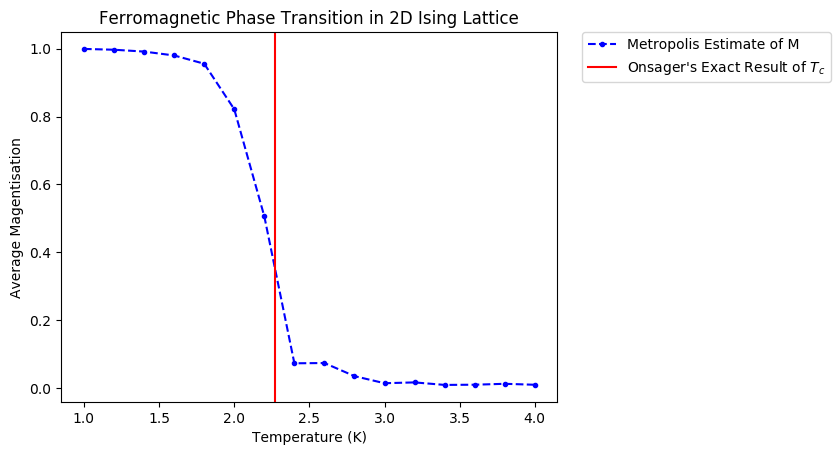

PyObject <matplotlib.legend.Legend object at 0x32d6e9350>

In [15]:
MC_plotter(Metropolis_Ising,[1000000,10,4],.2)

In [16]:
# MC_smartplot
# author(s): Joshuah Heath
#
# function that plots Monte Carlo data with error bars up to a specified error cutoff
#
#==============================================================================================#

function MC_error(f::Function,Param_List::Any,t::Any)

    N = Int64(Param_List[1])
    S = Int64(Param_List[2])
    T = Float64(Param_List[3])
    
    start_temp =1 # beginning temp set to 1 K
    
    MC_data=[parallel_calc(f,[N,S,temp]) for temp in start_temp:t:T]   
    
    mag_list=[MC_data[i][1] for i in 1:length(MC_data)]
    
    error_list=[MC_data[i][2] for i in 1:length(MC_data)]
    
    errorbar(collect(start_temp:t:T),mag_list,yerr=error_list,linestyle="--",marker=".",
            color="blue",label=string("Metropolis Estimate of M"))
        
    axvline(x=2/(np.log(1+np.sqrt(2))),linestyle="-",color="red",label=string(L"Onsager's Exact Result of $T_c$")) 

    
    title(string("Ferromagnetic Phase Transition in 2D Ising Lattice"))   # make titles and labels
    ylabel("Average Magentisation")
    xlabel("Temperature (K)")
    
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   # make legend

end

MC_error (generic function with 1 method)

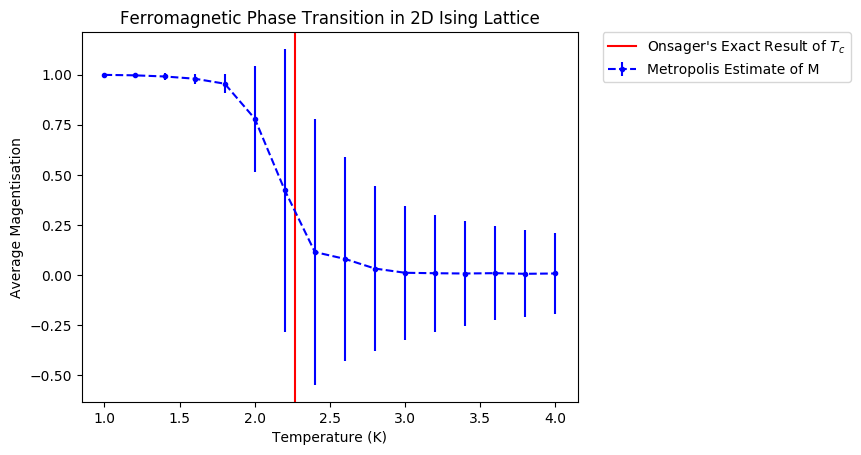

PyObject <matplotlib.legend.Legend object at 0x32da16bd0>

In [17]:
MC_error(Metropolis_Ising,[1000000,10,4],.2)

In [ ]:
MC_error(Metropolis_Ising,[10000000,10,5],.2)